<a href="https://colab.research.google.com/github/Haimonti/CarePathways/blob/main/Copy_of_cp_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install  dgl -f https://data.dgl.ai/wheels/repo.html

Looking in links: https://data.dgl.ai/wheels/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 13.5 MB/s eta 0:00:00


In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.5 MB/s eta 0:00:00


In [ ]:
pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 522.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 36.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7028 sha256=7f8e5999fcc6c79edd63f639a214af9d20d45d16576032c7af8c5bcae55afbf9
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf

In [ ]:
import optuna
from optuna.trial import TrialState

In [ ]:
import numpy as np

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/healthcare_gnn/someTest.csv")
df.shape

Mounted at /content/drive


(145598, 3)

In [ ]:
import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.data
from dgl.data import DGLDataset
from dgl.data import CSVDataset
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

class CarePathwaysDataset(DGLDataset):

        def __init__(self):
          super().__init__(name="care_pthways")

        def process(self):
          nodes_data = pd.read_csv("/content/drive/MyDrive/healthcare_gnn/pt_pathways-v4.csv")
          print(nodes_data.shape)
          #Attribute names
          print(nodes_data.columns)
          node_feat = nodes_data.drop(['id','Mean HLOS'], axis=1)
          print(f"Node Features Dimension {node_feat.shape}")
          tsr_feat = torch. tensor(node_feat.values)
          torch.save(tsr_feat, 'data.pt')

          edges_data = pd.read_csv("/content/drive/MyDrive/healthcare_gnn/someTest.csv")
          #node_features = torch.from_numpy(nodes_data["age"].to_numpy())
          node_features = tsr_feat
          node_labels = torch.from_numpy(nodes_data["Mean HLOS"].astype(float).to_numpy())
          edge_features = torch.from_numpy(edges_data["Weight"].to_numpy())
          edges_src = torch.from_numpy(edges_data["Src"].to_numpy())
          edges_dst = torch.from_numpy(edges_data["Dst"].to_numpy())

          self.graph = dgl.graph((edges_src, edges_dst),num_nodes=nodes_data.shape[0])
          self.graph.ndata["feat"] = node_features
          self.graph.ndata["label"] = node_labels
          self.graph.edata["weight"] = edge_features

           # If your dataset is a node classification dataset, you will need to assign
          # masks indicating whether a node belongs to training, validation, and test set.
          n_nodes = nodes_data.shape[0]
          n_train = int(n_nodes * 0.6)
          #train_inst = pd.read_csv("/content/drive/MyDrive/CarePathways/ptTrainInd.csv")
          n_val = int(n_nodes * 0.2)
          #val_inst = pd.read_csv("/content/drive/MyDrive/CarePathways/ptValidInd.csv")
          n_test = 100
          #test_inst = pd.read_csv("/content/drive/MyDrive/CarePathways/ptTestInd.csv")
          train_mask = torch.zeros(n_nodes, dtype=torch.int)
          val_mask = torch.zeros(n_nodes, dtype=torch.int)
          test_mask = torch.zeros(n_nodes, dtype=torch.int)
          train_mask[:n_train] = int(1)
          val_mask[n_train : n_train + n_val] = int(1)
          test_mask[n_train + n_val :] = int(1)
          self.graph.ndata["train_mask"] = train_mask
          self.graph.ndata["val_mask"] = val_mask
          self.graph.ndata["test_mask"] = test_mask

        def __getitem__(self, i):
          return self.graph

        def __len__(self):
          return 1

dataset = CarePathwaysDataset()
g = dataset[0]
print(g)

# Gather statistics from the graph
print(f"Number of nodes {g.num_nodes}")
print(f"Number of edges {g.num_edges}")
#print(f"Average node degree {g.num_edges / g.num_nodes}")
#print(f"Number of training nodes {train_mask.shape}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(508, 45)
Index(['id', 'admission_disposition', 'age', 'sex', 'Hypertension',
       'Chronic cardiac disease (not hypertension)', 'N/A', 'Diabetes',
       'History of cancer [now in remission]', 'Other', 'Kidney disease',
       'Obesity', 'Asthma', 'Rheumatologic disorder',
       'Dementia [any etiology]', 'Chronic pulmonary (lung) disease',
       'Pregnancy', 'Stroke', 'Cancer [active only]', 'Liver disease',
       'Chronic renal', 'Chronic neurological disorder', 'Hematological',
       'reason_for_admission_ARDS (adult respiratory distress syndrome) [J80]',
       'reason_for_admission_Acquired respiratory distress syndrome [J80]',
       'reason_for_admission_COVID-19 [U07.1]',
       'reason_for_admission_COVID-19 determined by clinical diagnostic criteria [U07.2]',
       'reason_for_admission_COVID-19 virus infection [U07.1]',
       'reason_for_

In [ ]:
nodes_data = pd.read_csv("/content/drive/MyDrive/healthcare_gnn/pt_pathways-v4_reg.csv")
nodes_data['Unnamed: 0']

0        0
1        1
2        2
3        3
4        4
      ... 
503    503
504    504
505    505
506    506
507    507
Name: Unnamed: 0, Length: 508, dtype: int64

In [ ]:
class CarePathwaysDataset_reg(DGLDataset):

        def __init__(self):
          super().__init__(name="care_pthways")

        def process(self):
          nodes_data = pd.read_csv("/content/drive/MyDrive/healthcare_gnn/pt_pathways-v4_reg.csv")
          print(nodes_data.shape)
          #Attribute names
          print(nodes_data.columns)
          node_feat = nodes_data.drop(['id','Hospital LOS', 'Std Dev','Unnamed: 0','comorbidities_other','Mean HLOS'], axis=1) #LOS and std dev
          print(f"Node Features Dimension {node_feat.shape}")
          tsr_feat = torch. tensor(node_feat.values)
          torch.save(tsr_feat, 'data.pt')

          edges_data = pd.read_csv("/content/drive/MyDrive/healthcare_gnn/someTest.csv")
          #node_features = torch.from_numpy(nodes_data["age"].to_numpy())
          node_features = tsr_feat
          node_labels = torch.from_numpy(nodes_data["Hospital LOS"].astype(float).to_numpy()) #LOS
          edge_features = torch.from_numpy(edges_data["Weight"].to_numpy())
          edges_src = torch.from_numpy(edges_data["Src"].to_numpy())
          edges_dst = torch.from_numpy(edges_data["Dst"].to_numpy())

          self.graph = dgl.graph((edges_src, edges_dst),num_nodes=nodes_data.shape[0])
          self.graph.ndata["feat"] = node_features
          self.graph.ndata["label"] = node_labels
          self.graph.edata["weight"] = edge_features

           # If your dataset is a node classification dataset, you will need to assign
          # masks indicating whether a node belongs to training, validation, and test set.
          n_nodes = nodes_data.shape[0]
          n_train = int(n_nodes * 0.6)
          #train_inst = pd.read_csv("/content/drive/MyDrive/CarePathways/ptTrainInd.csv")
          n_val = int(n_nodes * 0.2)
          #val_inst = pd.read_csv("/content/drive/MyDrive/CarePathways/ptValidInd.csv")
          n_test = 100
          #test_inst = pd.read_csv("/content/drive/MyDrive/CarePathways/ptTestInd.csv")

          train_mask = torch.zeros(n_nodes, dtype=torch.int)
          val_mask = torch.zeros(n_nodes, dtype=torch.int)
          test_mask = torch.zeros(n_nodes, dtype=torch.int)
          train_mask[:n_train] = int(1)
          val_mask[n_train : n_train + n_val] = int(1)
          test_mask[n_train + n_val :] = int(1)
          self.graph.ndata["train_mask"] = node_labels[:n_train]       #train_mask
          self.graph.ndata["val_mask"] =   node_labels[n_train : n_train + n_val]      #val_mask
          self.graph.ndata["test_mask"] =  node_labels[n_train + n_val :]    #test_mask

        def __getitem__(self, i):
          return self.graph

        def __len__(self):
          return 1
dataset_reg = CarePathwaysDataset_reg()
gg = dataset_reg[0]
print(gg)

# Gather statistics from the graph
print(f"Number of nodes {gg.num_nodes}")
print(f"Number of edges {gg.num_edges}")
#print(f"Average node degree {g.num_edges / g.num_nodes}")
#print(f"Number of training nodes {train_mask.shape}")

(508, 55)
Index(['Unnamed: 0', 'id', 'admission_disposition', 'age', 'sex',
       'Hospital LOS', 'Std Dev', 'Hypertension',
       'Chronic cardiac disease (not hypertension)', 'N/A', 'Diabetes',
       'History of cancer [now in remission]', 'Other', 'Kidney disease',
       'Obesity', 'Asthma', 'Rheumatologic disorder',
       'Dementia [any etiology]', 'Chronic pulmonary (lung) disease',
       'Pregnancy', 'Stroke', 'Cancer [active only]', 'Liver disease',
       'Chronic renal', 'Chronic neurological disorder', 'Hematological',
       'comorbidities_other', 'Mean HLOS',
       'reason_for_admission_ARDS (adult respiratory distress syndrome) [J80]',
       'reason_for_admission_Acquired respiratory distress syndrome [J80]',
       'reason_for_admission_Atypical pneumonia [J18.9]',
       'reason_for_admission_COVID-19 [U07.1]',
       'reason_for_admission_COVID-19 determined by clinical diagnostic criteria [U07.2]',
       'reason_for_admission_COVID-19 virus infection [U07.1]',

In [ ]:
gg.ndata['label'][gg.ndata['test_mask']]

tensor([21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 2

In [ ]:
# Training a Multilayer Perceptron (MLP)
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
  def __init__(self, hidden_channels):
      super().__init__()
      #torch.manual.seed(12113)
      self.lin1 = Linear(43, hidden_channels)
      self.lin2 = Linear(hidden_channels, 2)

  def forward(self,x):
      x = self.lin1(x)
      #x = x.relu()
      x = x.sigmoid()
      x = self.lin2(x)
      return x

#train_data_sz = 422
#modelMLP = MLP(train_data_sz, hidden_channels=16)
#print(modelMLP)

In [ ]:
import numpy as np
import torch
from torch.nn import Linear

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

#No GNNs involved -- simply run MLP on the data
nodes_data = pd.read_csv("/content/drive/MyDrive/healthcare_gnn/pt_pathways-v4.csv")
#print(nodes_data.shape)
#Attribute names
#print(nodes_data.columns)
node_feat = nodes_data.drop(['id','Mean HLOS'], axis=1)
print(f"Node features dimension: {node_feat.shape}")
tsr_feat = torch.tensor(node_feat.values)
tsr_feat = tsr_feat.to(torch.float32)
labels = torch.from_numpy(nodes_data["Mean HLOS"].astype(float).to_numpy())

#Split the data into train and test
n_data_sz = nodes_data.shape[0]
msk = np.random.rand(n_data_sz) < 0.8
#print(f"Mask {msk}")
nodes_data_train = tsr_feat[msk]
print(f"Size of training data {nodes_data_train.shape}")
nodes_data_test = tsr_feat[~msk]
print(f"Size of test data {nodes_data_test.shape}")

modelMLP = MLP(hidden_channels=16)
print(f"Model is: {modelMLP}")
#mdl = Linear(node_feat.shape[1], 2, bias=False)
#Define loss criterion
criterion = torch.nn.CrossEntropyLoss()
#Define optimizer
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=0.01, weight_decay=5e-4)

def train():
       optimizer.zero_grad()
       #print(f"Data type of model weight {mdl.weight.dtype}")
       #print(f"Dimension of model weight - first {modelMLP.lin1.weight.shape}")
       #print(f"Dimension of model weight - sec {modelMLP.lin2.weight.shape}")
       #print(f"Data type of the features {nodes_data_train.dtype}")
       #out = mdl(nodes_data_train)
       out = modelMLP(nodes_data_train)
       #print(out.size())
       #print(out.dtype)
       #print(labels[msk].dtype)
       #Check out the actual predictions
       #print(f"What is out? {out}")

       #Assume model is built on the entire dataset
       loss = criterion(out,labels[msk].to(torch.long))
       #print(f"Loss is {loss}")
       #val_loss = criterion(out["val_mask"],labels["val_mask"])
       loss.backward()
       optimizer.step()
       return loss

def test():
      #mdl.eval()
      modelMLP.eval()
      #outMLP = mdl(nodes_data_test)
      outMLP = modelMLP(nodes_data_test)
      pred = outMLP.argmax(dim=1)
      test_correct = pred == labels[~msk]
      test_acc = int(test_correct.sum()) / int(nodes_data_test.shape[0])
      return test_acc

for epoch in range (1, 10):
     loss_tr = train()
     test_acc = test()
     print(f"Epoch: {epoch: 1d}, Loss: {loss_tr: 0.4f}, Test Acc. {test_acc: 0.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Node features dimension: (508, 43)
Size of training data torch.Size([394, 43])
Size of test data torch.Size([114, 43])
Model is: MLP(
  (lin1): Linear(in_features=43, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)
Epoch:  1, Loss:  0.6238, Test Acc.  0.7105
Epoch:  2, Loss:  0.6195, Test Acc.  0.7105
Epoch:  3, Loss:  0.6189, Test Acc.  0.7105
Epoch:  4, Loss:  0.6167, Test Acc.  0.7105
Epoch:  5, Loss:  0.6136, Test Acc.  0.7105
Epoch:  6, Loss:  0.6108, Test Acc.  0.7105
Epoch:  7, Loss:  0.6086, Test Acc.  0.7105
Epoch:  8, Loss:  0.6069, Test Acc.  0.7105
Epoch:  9, Loss:  0.6052, Test Acc.  0.7105


In [ ]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h) #relu
        h = self.conv2(g, h)
        #m=nn.Linear(h.shape[1],h.shape[1]) #for regression
        #h=m(h)
        return h

# Create the model with given dimensions
print(g.ndata["feat"].shape)
model = GCN(g.ndata["feat"].shape[1], 32, 2)
print(model)

torch.Size([508, 43])
GCN(
  (conv1): GraphConv(in=43, out=32, normalization=both, activation=None)
  (conv2): GraphConv(in=32, out=2, normalization=both, activation=None)
)


In [ ]:
def train(g, model):
      #Select the Adam optimizer for no apparent reason
      optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
      best_val_acc = 0
      best_test_acc = 0

      features = g.ndata["feat"]
      print(f"Features are: {features}")
      labels = g.ndata["label"]
      #print(f"Labels are: {labels}")
      train_mask = g.ndata["train_mask"]
      #print(f"Train_mask {train_mask}")
      val_mask = g.ndata["val_mask"]
      test_mask = g.ndata["test_mask"]

      for e in range(50):
        # Forward
        logits = model(g, features)
        #print(f"Prediction is {logits}")
        # Compute prediction
        #logits=g.ndata["feat"]
        pred = logits.argmax(dim=1) #change it to = logits
        #print(pred[train_mask])
        #print(f"Prediction is {pred}")

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        #print(f"Data type {logits[train_mask].dtype}")
        #print(f"Data type {labels[train_mask].dtype}")
        loss = F.cross_entropy(logits[train_mask], labels[train_mask].to(torch.long))
        #print(f"Loss is {loss}")

        # Compute accuracy on training/validation/test #change it to mse
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print(
                f"In epoch {e}, loss: {loss:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}), test acc: {test_acc:.3f} (best {best_test_acc:.3f})"
            )


# Create the model with given dimensions
model = GCN(43,10, 2)
#print(model)
train(g,model)

Features are: tensor([[ 1, 74,  1,  ...,  0,  0,  0],
        [ 1, 61,  0,  ...,  0,  0,  0],
        [ 1, 58,  0,  ...,  0,  0,  0],
        ...,
        [ 1, 74,  1,  ...,  0,  0,  0],
        [ 1, 48,  0,  ...,  0,  0,  0],
        [ 1, 73,  1,  ...,  0,  0,  0]])
In epoch 0, loss: 8.955, val acc: 0.199 (best 0.199), test acc: 0.203 (best 0.203)
In epoch 5, loss: 2.393, val acc: 0.199 (best 0.199), test acc: 0.203 (best 0.203)
In epoch 10, loss: 2.536, val acc: 0.801 (best 0.801), test acc: 0.797 (best 0.797)
In epoch 15, loss: 0.722, val acc: 0.801 (best 0.801), test acc: 0.797 (best 0.797)
In epoch 20, loss: 1.410, val acc: 0.199 (best 0.801), test acc: 0.203 (best 0.797)
In epoch 25, loss: 0.672, val acc: 1.000 (best 1.000), test acc: 1.000 (best 1.000)
In epoch 30, loss: 0.847, val acc: 0.801 (best 1.000), test acc: 0.797 (best 1.000)
In epoch 35, loss: 0.805, val acc: 0.199 (best 1.000), test acc: 0.203 (best 1.000)
In epoch 40, loss: 0.657, val acc: 0.199 (best 1.000), test ac

In [ ]:
#best_pred_array=[]
def train_reg(g, model):
      #Select the Adam optimizer for no apparent reaspon
      optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
      best_val_acc = np.inf
      best_test_acc = np.inf
      best_pred_array=[]

      features = g.ndata["feat"]
      print(f"Features are: {features}")
      labels = g.ndata["label"]  #change it to length of stay

      #print(f"Labels are: {labels}")
      n_nodes = nodes_data.shape[0]
      n_train = int(n_nodes * 0.6)
      n_val = int(n_nodes * 0.2)
      n_test = 100
      train_mask = labels[:n_train]
      #print(f"Train_mask {train_mask}")
      val_mask = labels[n_train : n_train + n_val]
      test_mask = labels[n_train + n_val :]

      for e in range(50): #50
        # Forward
        logits = model(g, features)
        #print(f"Prediction is {logits}")
        # Compute prediction
        #logits=g.ndata["feat"]
        pred = logits #logits.argmax(dim=1)
        #print(pred[train_mask])
        #print(f"Prediction is {pred}")

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        #print(f"Data type {logits[train_mask].dtype}")
        #print(f"Data type {labels[train_mask].dtype}")

        #loss = F.cross_entropy(logits[train_mask], labels[train_mask].to(torch.long))
        logits=logits.flatten()
        maeloss=torch.nn.L1Loss()
        loss=maeloss(logits[:n_train], train_mask.to(torch.long))
        #print(logits[train_mask])
        #print(labels[train_mask])
        #print(f"Loss is {loss}")

        # Compute accuracy on training/validation/test
        train_acc = ((pred[:n_train] - train_mask).float()**2).mean() #(pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = ((pred[n_train : n_train + n_val] - val_mask).float()**2).mean() #(pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = ((pred[n_train + n_val :] - test_mask).float()**2).mean() #(pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc > val_acc: #if the MSE is smaller
            best_val_acc = val_acc
            best_test_acc = test_acc
            best_pred_array=pred[n_train + n_val :]

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print(
                f"In epoch {e}, loss: {loss:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}), test acc: {test_acc:.3f} (best {best_test_acc:.3f})"
            )
      return best_pred_array


# Create the model with given dimensions
model_reg = GCN(gg.ndata["feat"].shape[1],10, 1)
#print(model)
b=train_reg(gg,model_reg)

Features are: tensor([[ 1, 74,  1,  ...,  0,  0,  0],
        [ 1, 61,  0,  ...,  0,  0,  0],
        [ 1, 58,  0,  ...,  0,  0,  0],
        ...,
        [ 1, 74,  1,  ...,  0,  0,  0],
        [ 1, 48,  0,  ...,  0,  0,  0],
        [ 1, 73,  1,  ...,  0,  0,  0]])
In epoch 0, loss: 9.059, val acc: 260.779 (best 260.779), test acc: 124.294 (best 124.294)
In epoch 5, loss: 7.585, val acc: 176.503 (best 176.503), test acc: 82.736 (best 82.736)
In epoch 10, loss: 7.787, val acc: 167.762 (best 166.793), test acc: 83.197 (best 83.503)
In epoch 15, loss: 7.522, val acc: 183.538 (best 166.793), test acc: 84.051 (best 83.503)
In epoch 20, loss: 7.604, val acc: 197.733 (best 166.793), test acc: 88.910 (best 83.503)
In epoch 25, loss: 7.532, val acc: 189.346 (best 166.793), test acc: 85.764 (best 83.503)
In epoch 30, loss: 7.549, val acc: 179.753 (best 166.793), test acc: 83.223 (best 83.503)
In epoch 35, loss: 7.521, val acc: 183.657 (best 166.793), test acc: 84.087 (best 83.503)
In epoch 40,

In [ ]:
len(gg.ndata['label'])

508

In [ ]:
b.flatten()

tensor([10.6490, 11.1356, 12.6123, 13.6021, 13.0533, 11.1356,  5.5421, 14.9048,
        10.3443, 14.0721,  9.6797, 11.0858, 13.8120, 14.2992, 14.9020, 13.8722,
         7.1134, 14.9020, 14.7286, 14.0721, 14.2992, 12.6123, 11.1356, 10.6490,
        13.3184, 14.7191, 11.9227, 13.9637, 14.5996, 14.9048, 14.0721, 15.1905,
        12.3659, 13.6021, 11.8768, 12.4450, 12.8042, 15.0928, 12.8042, 14.7286,
        14.9020, 14.2992, 14.5996, 11.0858, 14.6867, 14.7219, 10.6490, 11.2912,
        14.5996, 14.7286, 14.7192, 12.9109, 14.5996, 12.4450, 14.9020,  7.3560,
        14.7191, 14.9048, 15.1201, 14.7219, 13.3184, 15.1201, 15.1801, 11.1356,
        14.5990, 14.7191, 13.0532, 13.5653, 15.1201, 14.5996, 10.7089, 12.6123,
         3.6736, 15.1588, 11.1356, 13.5653, 14.6037, 13.5653, 14.0721, 12.9109,
        14.6354, 13.1444,  6.3876, 14.7481, 14.2992, 14.7286, 14.9048, 13.3184,
         9.3715, 15.1801, 13.3184, 11.0858, 15.1801, 13.9637, 14.9020, 12.6123,
        14.6354, 12.4272, 15.1801, 14.57

In [ ]:
gg.ndata['label'][405:]

tensor([28.,  6., 10.,  1.,  9., 13.,  8.,  7., 13., 44.,  4.,  5.,  4.,  9.,
        17., 14.,  7., 28., 17.,  9.,  5., 30.,  8.,  8.,  2.,  5.,  5., 32.,
         4., 24.,  3.,  8., 10.,  4.,  3., 13.,  3., 10., 27.,  8.,  2.,  9.,
        39., 11., 25.,  3.,  8., 10., 34., 14., 31.,  4., 10.,  7.,  6.,  3.,
         5.,  9.,  6.,  4.,  6.,  6.,  6., 10., 36.,  3.,  6.,  4.,  4., 26.,
         7.,  4.,  3.,  7., 10.,  8., 11.,  5., 14.,  7.,  8.,  8.,  7.,  7.,
         9., 12., 21.,  4.,  3.,  9.,  5., 10., 12., 18., 11.,  2.,  4.,  2.,
        13., 19.,  9.,  7.,  5.], dtype=torch.float64)

In [ ]:
import matplotlib.pyplot as plt

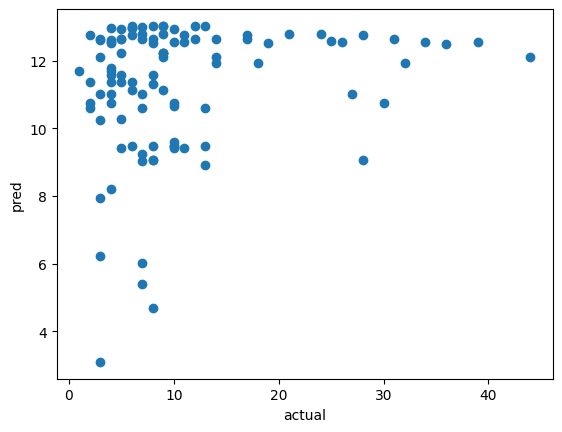

In [ ]:
plt.scatter(gg.ndata['label'][405:].detach().numpy(), b.flatten().detach().numpy())
plt.ylabel("pred")
plt.xlabel("actual")
plt.show()

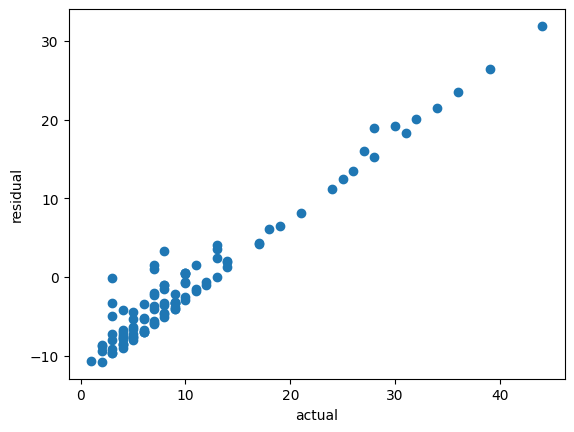

In [ ]:
plt.scatter(gg.ndata['label'][405:].detach().numpy(),gg.ndata['label'][405:].detach().numpy()- b.flatten().detach().numpy())
plt.ylabel("residual")
plt.xlabel("actual")
plt.show()

In [ ]:
#set up the regression model
#difference between hop and neighbors
def objective(trial):



  num_layers=trial.suggest_int("num_layer", 1,3)
  hidden_size=trial.suggest_int("hidden_size",16,512)
  dropout=trial.suggest_uniform("dropout",0.1,0.5)
  lr=trial.suggest_loguniform("learning_rate",1e-5,5e-1)
  optimizer_name=trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
  best_val_acc = 0
  best_test_acc = 0
  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
  features = g.ndata["feat"]
  labels = g.ndata["label"]
      #print(f"Labels are: {labels}")
  train_mask = g.ndata["train_mask"]
      #print(f"Train_mask {train_mask}")
  val_mask = g.ndata["val_mask"]
  test_mask = g.ndata["test_mask"]
  for e in range(50):
        # Forward
        logits = model(g, features)
        #print(f"Prediction is {logits}")
        # Compute prediction
        #logits=g.ndata["feat"]
        pred = logits.argmax(dim=1)
        #print(pred[train_mask])
        #print(f"Prediction is {pred}")

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        #print(f"Data type {logits[train_mask].dtype}")
        #print(f"Data type {labels[train_mask].dtype}")
        loss = F.cross_entropy(logits[train_mask], labels[train_mask].to(torch.long))
        #print(f"Loss is {loss}")

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
        trial.report(test_acc, e)
        if trial.should_prune():
          raise optuna.exceptions.TrialPruned()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
model = GCN(43,10, 2)
#print(model)
objective(g,model)

[I 2023-09-01 06:00:20,181] A new study created in memory with name: no-name-5f925152-c991-421c-9015-540fe9cf647b
[W 2023-09-01 06:00:20,187] Trial 0 failed with parameters: {} because of the following error: TypeError("objective() missing 2 required positional arguments: 'model' and 'trial'").
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
TypeError: objective() missing 2 required positional arguments: 'model' and 'trial'
[W 2023-09-01 06:00:20,190] Trial 0 failed with value None.


TypeError: ignored

In [ ]:
param={
    "num_layers":trial.suggest_int("num_layer", 1,3),
      "hidden_size": trial.suggest_int("hidden_size",16,512),
      "dropout": trial.suggest_uniform("dropout",0.1,0.5),
      "learning_rate": trial.suggest_loguniform("learning_rate",1e-5,5e-1),
      "optimizer_name" : trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
}